In [1]:
import pandas as pd
import numpy as np

from gtda.homology import CubicalPersistence

from gtda.diagrams import Amplitude
from gtda.diagrams import PersistenceEntropy
from gtda.diagrams import PersistenceLandscape
from gtda.diagrams import NumberOfPoints

from gtda.images import Binarizer
from gtda.images import RadialFiltration
from gtda.images import HeightFiltration

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

from datetime import datetime

In [2]:
X1, y1 = fetch_openml("mnist_784", version=1, return_X_y=True)
print(f"X shape: {X1.shape}, y shape: {y1.shape}")

X shape: (70000, 784), y shape: (70000,)


In [3]:
X = pd.DataFrame.to_numpy(X1)

# Reshape to (n_samples, n_pixels_x, n_pixels_y)
X = X.reshape((-1, 28, 28))  # -1 means that first dimension as an unknown and we want numpy to figure it out
print(X.shape, X.ndim)

y = pd.Series.to_numpy(y1)


(70000, 28, 28) 3


In [4]:
# Select train and test data sets
train_size, test_size = 10000, 300
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=train_size, test_size=test_size, stratify=y, random_state=666)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_train shape: (10000, 28, 28), y_train shape: (10000,)
X_test shape: (300, 28, 28), y_test shape: (300,)


In [5]:
# create array with features using persistence diagram:
# Entropy, Amplitude, Number of points, multiple radial and height filtrations

def process_data(im_data, center_lst, direction_lst):

    im_features = np.array([])
    
    binarizer = Binarizer(threshold=0.4)
    for filtr_center in center_lst:
        radial_filtration = RadialFiltration(center=filtr_center)
        cubical_persistence = CubicalPersistence(n_jobs=-1)
        im_binarized = binarizer.fit_transform(im_data)
        im_filtration = radial_filtration.fit_transform(im_binarized)
        im_cubical = cubical_persistence.fit_transform(im_filtration)
        im_pe = PersistenceEntropy().fit_transform(im_cubical)
        im_num_of_points = NumberOfPoints().fit_transform(im_cubical)
        im_ampl = Amplitude(metric='landscape').fit_transform(im_cubical)
        
        im_features = np.append(im_features , im_pe)
        im_features = np.append(im_features , im_num_of_points)
        im_features = np.append(im_features , im_ampl)

    for filtr_dir in direction_lst:
        height_filtration = HeightFiltration(direction=filtr_dir)
        cubical_persistence = CubicalPersistence(n_jobs=-1)
        im_binarized = binarizer.fit_transform(im_data)
        im_filtration = height_filtration.fit_transform(im_binarized)
        im_cubical = cubical_persistence.fit_transform(im_filtration)
        im_pe = PersistenceEntropy().fit_transform(im_cubical)
        im_num_of_points = NumberOfPoints().fit_transform(im_cubical)
        im_ampl = Amplitude(metric='landscape').fit_transform(im_cubical)
        
        im_features = np.append(im_features , im_pe)
        im_features = np.append(im_features , im_num_of_points)
        im_features = np.append(im_features , im_ampl)
        
    return im_features


In [6]:
direction_list = [np.array([1, 0]), np.array([1, 1]), np.array([0, 1]),
                  np.array([-1, 1]), np.array([-1, 0]), np.array([-1, -1]), 
                  np.array([0, -1]), np.array([1, -1])]

center_list = [np.array([6, 20]), np.array([20, 6]), np.array([13, 6]),
               np.array([6, 13]), np.array([13, 13]), np.array([20, 13]),
               np.array([13, 20]), np.array([6, 6]),  np.array([20, 20])]

num_of_objects_train = X_train.shape[0]
num_of_objects_test = X_test.shape[0]

num_of_features = 6 * len(center_list) + 6 * len(direction_list)
X_features_train = np.zeros((num_of_objects_train, num_of_features))
X_features_test = np.zeros((num_of_objects_test, num_of_features))

print(X_features_train.shape, X_features_test.shape)
print(y_train.shape, y_test.shape)

(10000, 102) (300, 102)
(10000,) (300,)


In [7]:
# create array with features for train data set

print('start ', datetime.now())

for i in range(num_of_objects_train):
    im = X_train[i][None, :, :]
    features = process_data(im, center_list, direction_list)
    
    X_features_train[i,:] = features
    
print('end   ', datetime.now())


start  2024-10-14 14:34:08.376231
end    2024-10-14 15:28:56.603332


In [8]:
# create array with features for test data set

print('start ', datetime.now())

for i in range(num_of_objects_test):
    im = X_test[i][None, :, :]
    features = process_data(im, center_list, direction_list)
        
    X_features_test[i,:] = features
    
print('end   ', datetime.now())


start  2024-10-14 15:36:21.037997
end    2024-10-14 15:37:31.005958


In [9]:
import tensorflow.keras

from keras import models
from keras import layers


### Data standartization: mean=0, std=1

In [10]:
mean = X_features_train.mean(axis=0)  #axis=0 calculate mean by each column, axis=1 - by rows
X_features_train -= mean
std = X_features_train.std(axis=0)
X_features_train /= std

X_features_test -= mean
X_features_test /= std


In [11]:
# take 500 samples in our training data to use as a validation set:

X_features_val = X_features_train[:500]
partial_X_features_train = X_features_train[500:]


In [12]:
def to_one_hot(labels, dimension=10):
# array labels contains string elemnts, need to convert them into integers
    labels_int = [int(numeric_string) for numeric_string in labels]
    results = np.zeros((len(labels), dimension))

    for i, label in enumerate(labels_int):
        results[i, label] = 1.
    return results


In [13]:
# Vectorized training labels
one_hot_y_train = to_one_hot(y_train)
# Vectorized test labels
one_hot_y_test = to_one_hot(y_test)

one_hot_y_train_val = one_hot_y_train[:500]
one_hot_y_train_partial = one_hot_y_train[500:]

In [14]:
print(one_hot_y_train.shape, one_hot_y_train_partial.shape, one_hot_y_train_val.shape, one_hot_y_test.shape)


(10000, 10) (9500, 10) (500, 10) (300, 10)


In [36]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(num_of_features,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))


In [37]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print(model.summary())

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_19 (Dense)                     │ (None, 64)                  │           6,592 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,402 (44.54 KB)

 Trainable params: 11,402 (44.54 KB)

 Non-trainable params: 0 (0.00 B)

None


In [38]:
history = model.fit(partial_X_features_train,
                    one_hot_y_train_partial,
                    epochs=20,
                    batch_size=512,
                    validation_data=(X_features_val, one_hot_y_train_val))

Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3995 - loss: 1.8961 - val_accuracy: 0.7700 - val_loss: 0.9512
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7723 - loss: 0.9175 - val_accuracy: 0.8060 - val_loss: 0.6378
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8155 - loss: 0.6539 - val_accuracy: 0.8540 - val_loss: 0.5036
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8540 - loss: 0.5083 - val_accuracy: 0.8680 - val_loss: 0.4428
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8732 - loss: 0.4334 - val_accuracy: 0.8860 - val_loss: 0.3931
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8877 - loss: 0.3922 - val_accuracy: 0.8900 - val_loss: 0.3672
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8955 - loss: 0.3518 - val_accuracy: 0.8980 - val_loss: 0.3533
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9029 - loss: 0.3235 - val_accuracy: 0.8980 - val_loss

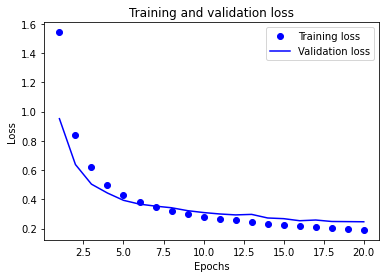

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

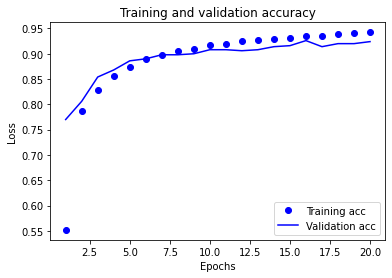

In [40]:
plt.clf()   # clear figure

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### It seems that the network starts overfitting after 12 epochs. Let's train a new network from scratch for 12 epochs, then evaluate it on the test set.

In [41]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(num_of_features,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(partial_X_features_train,
          one_hot_y_train_partial,
          epochs=12,
          batch_size=512,
          validation_data=(X_features_val, one_hot_y_train_val))


Epoch 1/12
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3990 - loss: 1.8267 - val_accuracy: 0.7660 - val_loss: 0.9724
Epoch 2/12
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7601 - loss: 0.9479 - val_accuracy: 0.8140 - val_loss: 0.6827
Epoch 3/12
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8168 - loss: 0.6708 - val_accuracy: 0.8440 - val_loss: 0.5483
Epoch 4/12
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8390 - loss: 0.5546 - val_accuracy: 0.8580 - val_loss: 0.4745
Epoch 5/12
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8599 - loss: 0.4737 - val_accuracy: 0.8740 - val_loss: 0.4190
Epoch 6/12
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8757 - loss: 0.4205 - val_accuracy: 0.8860 - val_loss: 0.3793
Epoch 7/12
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8871 - loss: 0.3772 - val_accuracy: 0.8920 - val_loss: 0.3639
Epoch 8/12
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9013 - loss: 0.3352 - val_accuracy: 0.8880 - val_loss

In [42]:
results = model.evaluate(X_features_test, one_hot_y_test)
#print(results, type(results))

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9212 - loss: 0.2966 


### Generating predictions on new data

In [43]:
predictions = model.predict(X_features_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [44]:
pred_cat = np.argmax(predictions, axis = 1)
print(len(pred_cat), len(y_test))


300 300


In [45]:
j=0
for i in range(len(pred_cat)):
   if pred_cat[i] == int(y_test[i]):
    j +=1
   else:
    print(i, pred_cat[i], int(y_test[i]))

print(j, j*100/len(pred_cat))


15 9 4
52 1 9
55 7 2
58 2 1
60 8 2
62 8 0
66 6 8
78 0 9
90 8 6
107 7 6
115 8 2
143 1 7
144 2 7
167 8 6
195 9 8
198 7 2
211 6 0
217 5 3
235 7 2
257 0 8
258 7 3
259 7 9
264 6 0
277 9 8
287 3 5
275 91.66666666666667
